# Entrenamiento de Clasificación de Género (UTKFace) - PyTorch

##  Descargar y descomprimir el dataset desde Google Drive (.zip)
Usamos gdown para descargar y zipfile para descomprimir.

In [ ]:
# Instalación e importación de librerías


import gdown
import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image #Abrir imagenes
import numpy as np #Manejar arrglos numericos
from collections import Counter #Contar ocurrencias
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report #Para calcular metricas de evaluacion
from collections import defaultdict #Usar diccionarios con valores por defecto

##Importar librerías necesarias

In [ ]:
# Descargar y descomprimir UTKFace
file_id = "12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx"
output_zip = "UTKFace.zip"
if not os.path.exists(output_zip):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)
if not os.path.exists("UTKFace"):
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall("UTKFace")

Downloading...
From (original): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx
From (redirected): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx&confirm=t&uuid=8d95aaa3-2d31-4032-ae42-2e94b020312a
To: /content/UTKFace.zip
100%|██████████| 1.40G/1.40G [00:25<00:00, 55.5MB/s]


## Organizacion


In [ ]:
# Configuración centralizada
class Config:
    DATA_DIR = "UTKFace"              # Ruta al dataset
    BATCH_SIZE = 64                    # Tamaño de lote
    NUM_EPOCHS = 15                    # Número de épocas de entrenamiento
    LR = 1e-4                          # Tasa de aprendizaje
    PATIENCE = 3                       # Paciencia para early stopping
    IMG_SIZE = 224                     # Tamaño al que se redimensionan las imágenes
    SPLIT_RATIO = 0.8                 # Porcentaje de datos de entrenamiento
    SEED = 42                          # Semilla para reproducibilidad
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Establecer semilla para reproducibilidad
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

## Dataset personalizado

In [ ]:
class UTKFaceDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path #Ruta con las carpetas con imagenes
        self.transform = transform #Recibe un transform de torchvision
        self.image_files = [] # Inicializa self.image_files para almacenar los nombres válidos.
        self._validate_and_prepare_data() #Llama al método privado _validate_and_prepare_data() para limpiar y validar el dataset.

    def _validate_and_prepare_data(self):   #Recorre los archivos e ignora  los que no son imagenes
        """Valida y prepara los datos, mostrando estadísticas"""
        valid_files = []
        invalid_files = []

        for fname in os.listdir(self.folder_path):
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            try:
                partes = fname.split("_")                   #Extra el genero del nombre del archivo
                if len(partes) >= 3 and partes[1].isdigit():
                    genero = int(partes[1])
                    if genero in [0, 1]:
                        valid_files.append(fname)
                    else:
                        invalid_files.append(fname)
                else:
                    invalid_files.append(fname)
            except Exception as e:
                invalid_files.append(fname)

        self.image_files = valid_files
        print(f"\nEstadísticas del Dataset:")
        print(f"- Imágenes válidas: {len(valid_files)}")
        print(f"- Imágenes descartadas: {len(invalid_files)}")
        print(f"- Distribución de clases: {Counter([int(f.split('_')[1]) for f in valid_files])}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)

        try:
            image = Image.open(img_path).convert("RGB")    #Abre la imagen con pil y la convierte en RGB
            genero = int(img_name.split("_")[1])  #Extrae el genero

            if self.transform:
                image = self.transform(image)

            return image, genero, img_name
        except Exception as e:
            print(f"Error procesando {img_name}: {str(e)}")  #Devuelva la tupla (imagen_transformada, género, nombre_del_archivo)
            # Devolver un ejemplo aleatorio como fallback
            return self[np.random.randint(0, len(self)-1)]

## Transformaciones con aumento de datos


In [ ]:
def get_transforms(augment=True): #Para tener mas datos
    """Devuelve transformaciones con/sin aumento de datos"""
    base_transforms = [
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),      # Redimensiona la imagen al tamaño fijo (ej: 224x224).
        transforms.ToTensor(), #Convierte la imagen de PIL.Image o numpy.ndarray a un tensor de PyTorch
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #	Normaliza los valores RGB por canal. Se suelen usar estos valores para modelos preentrenados en ImageNet.
    ]

    if augment:
        augment_transforms = [
            transforms.RandomHorizontalFlip(p=0.5), #Invierte horizontalmente la imagen con 50% de probabilidad.
            transforms.RandomRotation(degrees=15),  #Rota la imagen aleatoriamente hasta ±15°.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #Modifica brillo, contraste y saturación aleatoriamente
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), #Aplica traslaciones aleatorias de hasta el 10% en cada eje.
            transforms.RandomGrayscale(p=0.1) #Convierte la imagen a escala de grises con 10% de probabilidad.

        ]
        return transforms.Compose(augment_transforms + base_transforms) #Si augment=True, se aplican primero los aumentos, luego el resize y la normalización.
    return transforms.Compose(base_transforms) #Si augment=False, se usan solo las transformaciones base

## Configuracion de dispositivo

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


## Modelo con finetuning


In [ ]:
def build_model(architecture="resnet18"):
    """Construye y configura el modelo con fine-tuning"""
    if architecture == "resnet18":
        model = models.resnet18(pretrained=True)
        # Congelar todas las capas
        for param in model.parameters():
            param.requires_grad = False
        # Descongelar solo layer4
        for param in model.layer4.parameters():
            param.requires_grad = True
        # Reemplazar capa final
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    elif architecture == "resnet50":
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    elif architecture == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        # Congelar todas las capas
        for param in model.parameters():
            param.requires_grad = False
        # Descongelar solo las capas del último bloque (aproximado)
        for param in model.features[-1].parameters():
            param.requires_grad = True
        # Reemplazar classifier
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    else:
        raise ValueError(f"Arquitectura '{architecture}' no soportada.")

    return model.to(Config.DEVICE)



##Entrenamiento, modelo preentrenado y errores

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader):
        self.model = model.to(Config.DEVICE)  # Asegura modelo en dispositivo correcto
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.BCEWithLogitsLoss()

        # Solo optimiza parámetros entrenables (fine-tuned)
        trainable_params = filter(lambda p: p.requires_grad, self.model.parameters())
        self.optimizer = optim.AdamW(trainable_params, lr=Config.LR)

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', patience=2, factor=0.5, verbose=True
        )
        self.best_val_acc = 0.0
        self.history = defaultdict(list)

    def train_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, targets, _ in self.train_loader:
            images = images.to(Config.DEVICE)
            targets = targets.float().unsqueeze(1).to(Config.DEVICE)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        avg_loss = running_loss / total
        accuracy = correct / total
        return avg_loss, accuracy

    def validate(self, save_misclassified=False):
        self.model.eval()
        running_loss, correct, total = 0.0, 0, 0
        misclassified = []

        with torch.no_grad():
            for images, targets, img_names in self.val_loader:
                images = images.to(Config.DEVICE)
                targets = targets.float().unsqueeze(1).to(Config.DEVICE)

                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item() * images.size(0)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                correct += (preds == targets).sum().item()
                total += targets.size(0)

                if save_misclassified:
                    for i in range(len(preds)):
                        if preds[i] != targets[i]:
                            misclassified.append((
                                img_names[i],
                                targets[i].item(),
                                preds[i].item(),
                                probs[i].item()
                            ))

        avg_loss = running_loss / total
        accuracy = correct / total
        return avg_loss, accuracy, misclassified

    def train(self):
        early_stop_counter = 0

        for epoch in range(Config.NUM_EPOCHS):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, _ = self.validate()

            self.scheduler.step(val_acc)

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                }, 'best_model.pth')
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            print(f"Epoch {epoch + 1}/{Config.NUM_EPOCHS}")
            print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
            print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
            print(f"LR: {self.optimizer.param_groups[0]['lr']:.2e}")
            print("-" * 50)

            if early_stop_counter >= Config.PATIENCE:
                print("Early stopping triggered!")
                break
        return self.history

## Visualizacion


In [ ]:
def plot_confusion_matrix(model, dataloader, class_names=['Female', 'Male']):
    """Visualiza matriz de confusión para clasificación binaria"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images.to(Config.DEVICE)
            labels = labels.to(Config.DEVICE).float()  # ✅ Asegura que las labels estén en float

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # ✅ Convierte logits a probabilidades
            preds = (probs > 0.5).long().squeeze(1)  # ✅ Umbral para clasificación

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy().astype(int))  # ✅ Convertir a int para matriz de confusión

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title('Confusion Matrix', pad=20)
    plt.xlabel('Predicted Label', labelpad=10)
    plt.ylabel('True Label', labelpad=10)

    # Agregar valores en las celdas
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f"{cm[i, j]}",
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metrics(history):
    """Dibuja curvas de pérdida y precisión durante el entrenamiento"""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Flujo de llamadas





Estadísticas del Dataset:
- Imágenes válidas: 24104
- Imágenes descartadas: 2
- Distribución de clases: Counter({0: 12581, 1: 11523})

Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15
Train Loss: 0.4504 | Acc: 0.7921
Val   Loss: 0.3397 | Acc: 0.8569
LR: 1.00e-04
--------------------------------------------------
Epoch 2/15
Train Loss: 0.3660 | Acc: 0.8339
Val   Loss: 0.3137 | Acc: 0.8666
LR: 1.00e-04
--------------------------------------------------
Epoch 3/15
Train Loss: 0.3468 | Acc: 0.8443
Val   Loss: 0.3022 | Acc: 0.8728
LR: 1.00e-04
--------------------------------------------------
Epoch 4/15
Train Loss: 0.3394 | Acc: 0.8499
Val   Loss: 0.2890 | Acc: 0.8733
LR: 1.00e-04
--------------------------------------------------
Epoch 5/15
Train Loss: 0.3291 | Acc: 0.8520
Val   Loss: 0.2887 | Acc: 0.8764
LR: 1.00e-04
--------------------------------------------------
Epoch 6/15
Train Loss: 0.3193 | Acc: 0.8596
Val   Loss: 0.2768 | Acc: 0.8832
LR: 1.00e-04
--------------------------------------------------
Epoch 7/15
Train Loss: 0.3119 | Acc: 0.8654
Val   Loss: 0.2763 | Acc: 0.8816
LR: 1.00e-04
--------------------------------------------------
Epoch 8/15
Tr

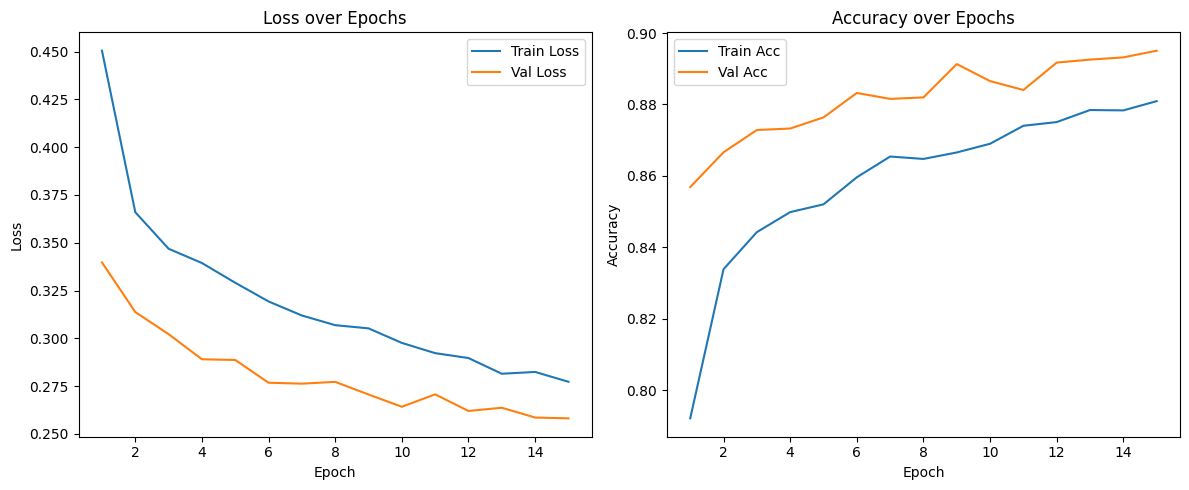


Evaluando modelo final...
Mejor precisión en validación: 0.8959


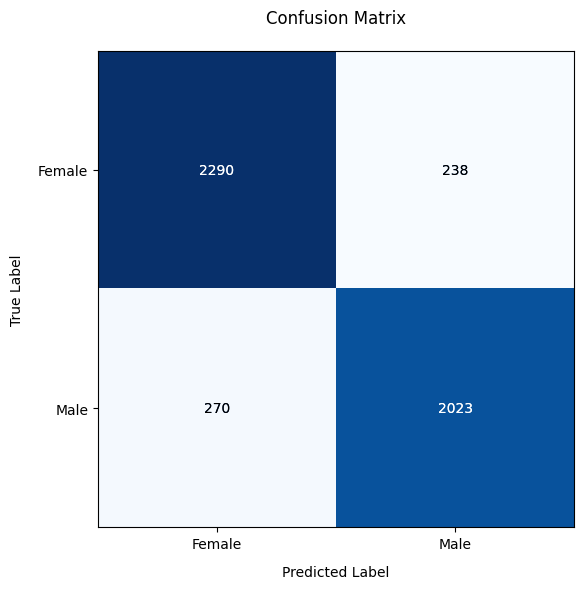


Ejemplos mal clasificados:
1. 2_0_0_20170110212644094.jpg - True: Female | Pred: Male | Conf: 0.51
2. 8_1_4_20170109202746183.jpg - True: Male | Pred: Female | Conf: 0.23
3. 36_1_1_20170116002211364.jpg - True: Male | Pred: Female | Conf: 0.05
4. 16_0_0_20170117134536197.jpg - True: Female | Pred: Male | Conf: 0.66
5. 54_0_0_20170113210127471.jpg - True: Female | Pred: Male | Conf: 0.70


In [ ]:
def main():
    # Descargar y preparar datos
    if not os.path.exists(Config.DATA_DIR):
        download_and_extract_data()

    # Cargar dataset
    transform = get_transforms(augment=True)
    full_dataset = UTKFaceDataset(Config.DATA_DIR, transform=transform)

    # Dividir dataset
    train_size = int(Config.SPLIT_RATIO * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    # Crear dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(
        val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)

    # Inicializar modelo y entrenador
    model = build_model("efficientnet_b0")
    trainer = Trainer(model, train_loader, val_loader)

    # Entrenar modelo
    print("\nIniciando entrenamiento...")
    history = trainer.train()

    # Visualizar resultados
    plot_metrics(history)

    # Cargar mejor modelo
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # Evaluar modelo final
    print("\nEvaluando modelo final...")
    val_loss, val_acc, misclassified = trainer.validate(save_misclassified=True)
    print(f"Mejor precisión en validación: {val_acc:.4f}")

    # Visualizar matriz de confusión
    plot_confusion_matrix(model, val_loader)

    # Mostrar ejemplos mal clasificados
    if misclassified:
        print("\nEjemplos mal clasificados:")
        for i, (img_name, true, pred, conf) in enumerate(misclassified[:5]):
            print(f"{i+1}. {img_name} - True: {'Male' if true else 'Female'} | "
                  f"Pred: {'Male' if pred else 'Female'} | Conf: {conf:.2f}")

if __name__ == "__main__":
    main()

##
Ver errores

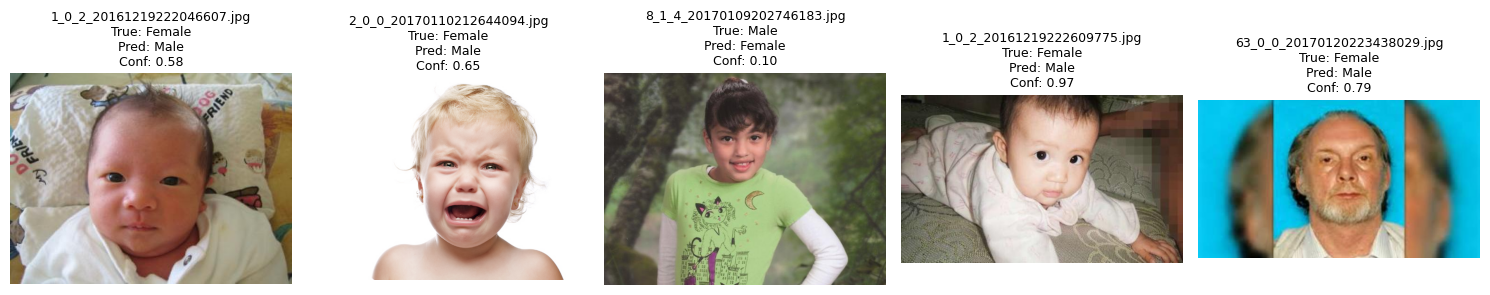

In [ ]:
misclassified = [
    ("1_0_2_20161219222046607.jpg", 0, 1, 0.58),
    ("2_0_0_20170110212644094.jpg", 0, 1, 0.65),
    ("8_1_4_20170109202746183.jpg", 1, 0, 0.10),
    ("1_0_2_20161219222609775.jpg", 0, 1, 0.97),
    ("63_0_0_20170120223438029.jpg", 0, 1, 0.79),
]

def show_misclassified_images(misclassified, data_dir, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, (img_name, true, pred, conf) in enumerate(misclassified[:num_images]):
        img_path = os.path.join(data_dir, img_name.strip())
        img = Image.open(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"{img_name}\nTrue: {'Male' if true else 'Female'}\n"
            f"Pred: {'Male' if pred else 'Female'}\nConf: {conf:.2f}",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

show_misclassified_images(misclassified, Config.DATA_DIR)